In [2]:
! rm -rf space-model
! git clone https://github.com/StepanTita/space-model.git

Cloning into 'space-model'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 47), reused 128 (delta 23), pack-reused 0
Receiving objects: 100% (155/155), 29.68 MiB | 26.11 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split

from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer

from train import run, get_preds_from_logits, prepare_dataset, init_space, init_base

from collections import Counter

In [15]:
# MODEL_NAME = 'FacebookAI/roberta-base'

SEED = 42
NUM_EPOCHS = 15
BATCH_SIZE = 64
MAX_SEQ_LEN = 512
LEARNING_RATE = 2e-5
MAX_GRAD_NORM = 1000

In [16]:
def prepare_hateoffensive(model_name, max_seq_len, device, seed):
    # 3 classes
    dataset = load_dataset("tdavidson/hate_speech_offensive")

    # Split the training set into training (80%) and validation (20%) sets
    train_testvalid = dataset['train'].train_test_split(test_size=0.2, seed=42)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

    # Assign datasets
    train_dataset = train_testvalid['train']
    val_dataset = test_valid['test']
    test_dataset = test_valid['train']

    dataset = DatasetDict({
        'train': train_dataset,
        'test': test_dataset,
        'val': val_dataset
    })

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_dataset = dataset.map(
        lambda x: tokenizer(x['tweet'], truncation=True, padding='max_length', max_length=max_seq_len,
                            return_tensors='pt'),
        batched=True)
    tokenized_dataset.set_format('torch', device=device)

    return tokenized_dataset.rename_columns({'class': 'label'})

def prepare_hatexplain(model_name, max_seq_len, device, seed):
    # 3 classes
    def get_label(annotators):
        # get the most common label using simple voting and accounting for batching
        return [Counter(anno['label']).most_common(1)[0][0] for anno in annotators]
            
    dataset = load_dataset('hatexplain')
    dataset = dataset.map(lambda x: {'label': get_label(x['annotators'])}, num_proc=4, batched=True)
    dataset['val'] = dataset['validation']
    del dataset['validation']
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset.map(lambda x: tokenizer(x['post_tokens'], truncation=True, padding='max_length', max_length=max_seq_len, return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    
    return tokenized_dataset

def prepare_emotions(model_name, max_seq_len, device, seed):
    # 28 classes
    emotions_1_df = pd.read_csv(f'data/goemotions_1.csv')
    emotions_2_df = pd.read_csv(f'data/goemotions_2.csv')
    emotions_3_df = pd.read_csv(f'data/goemotions_3.csv')

    emotions_df = pd.concat([
        emotions_1_df,
        emotions_2_df,
        emotions_3_df
    ], ignore_index=True, axis=0)
    
    labels = [
        'admiration',
        'amusement',
        'anger',
        'annoyance',
        'approval',
        'caring',
        'confusion',
        'curiosity',
        'desire',
        'disappointment',
        'disapproval',
        'disgust',
        'embarrassment',
        'excitement',
        'fear',
        'gratitude',
        'grief',
        'joy',
        'love',
        'nervousness',
        'optimism',
        'pride',
        'realization',
        'relief',
        'remorse',
        'sadness',
        'surprise',
        'neutral'
    ]
    emotions_df['label'] = emotions_df[labels].apply(lambda x: x.to_list(), axis=1)
    
    train_split, test_split = train_test_split(emotions_df, test_size=0.2, random_state=seed)
    test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=seed)
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_split[['text', 'label']]),
        'val': Dataset.from_pandas(test_split[['text', 'label']]),
        'test': Dataset.from_pandas(val_split[['text', 'label']]),
    })
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset
    tokenized_dataset = tokenized_dataset.map(
        lambda x: tokenizer(x['text'], truncation=True, padding='max_length', max_length=MAX_SEQ_LEN,
                            return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    return tokenized_dataset

def prepare_fake(model_name, max_seq_len, device, seed):
    train_df = pd.read_csv('data/fake_train.csv', index_col=0)
    train_df['final'] = 'Title: ' + train_df['title'] + ' Text: ' + train_df['text']
    
    train_df = train_df[train_df['title'].notnull() & train_df['text'].notnull()]
    
    test_df = pd.read_csv('data/fake_test.csv', index_col=0)
    test_df['final'] = 'Title: ' + test_df['title'] + ' Text: ' + test_df['text']
    
    train_split, test_split = train_test_split(train_df, test_size=0.2, random_state=seed)
    test_split, val_split = train_test_split(test_split, test_size=0.5, random_state=seed)
    
    dataset = DatasetDict({
        'train': Dataset.from_pandas(train_split[['final', 'label']]),
        'test': Dataset.from_pandas(test_split[['final', 'label']]),
        'val': Dataset.from_pandas(val_split[['final', 'label']])
    })
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    tokenized_dataset = dataset.map(lambda x: tokenizer(x['final'], truncation=True, padding=True, max_length=MAX_SEQ_LEN, return_tensors='pt'), batched=True)
    tokenized_dataset.set_format('torch', device=device)
    
    return tokenized_dataset

In [17]:
def train_wrapper(device_id, train_base, train_space, experiment_name, n_latent, config):
    def train():
        run({
            'experiment_name': experiment_name,
            
            'log_terminal': True,

            'device_id': device_id,
            'train_base': train_base,
            'train_space': train_space,

            'seed': SEED,
            'dataset_name': config['dataset_name'],
            'model_name': config['model_name'],

            'num_labels': config['num_labels'],
            'num_epochs': NUM_EPOCHS,
            'iterations': 1,

            'max_seq_len': MAX_SEQ_LEN,
            'batch_size': BATCH_SIZE,
            'lr': LEARNING_RATE,
            'fp16': False,
            'max_grad_norm': MAX_GRAD_NORM,
            'weight_decay': 0.01,
            'num_warmup_steps': 0,
            'gradient_accumulation_steps': 1,

            'n_latent': n_latent,
            'l1': config['l1'],
            'l2': config['l2'],
            'cross_entropy_weight': config['ce_w'],
            
            # funcs:
            'preds_from_logits_func': get_preds_from_logits,
            'get_data_func': config['prepare_dataset'],
            'init_space_func': init_space,
            'init_base_func': init_base
        })

    return train

In [18]:
latents = [2 ** i for i in range(2, 10)]
latents

[4, 8, 16, 32, 64, 128, 256, 512]

In [19]:
for lat in latents[1:]:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.01,
        'l2': 1e-7,
        'ce_w': 1.0,
        'model_name': 'FacebookAI/roberta-base',
        'dataset_name': 'imdb',
        'prepare_dataset': prepare_dataset,
        'num_labels': 2,
    })()

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 8, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_base_func': <function init_base at 0x770a25ce4ca0>}
Loading dataset...


Latents: 8


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 12322
Inter-space loss: 0.6304150223731995
Intra-space loss: 0.005828810390084982
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:49<00:00,  1.58it/s]

Train loss: 0.702047236049518 | Val loss: 0.6942880636529077
Train acc: 0.53815 | Val acc: 0.6628
CS Train acc: 0.49315 | CS Val acc: 0.479
Train f1: 0.4570663297691827 | Val f1: 0.6580057328462492
CS Train f1: 0.4559616594279253 | CS Val f1: 0.42337126510042355
Train precision: 0.5955495767651175 | Val precision: 0.6719671743695701
Train recall: 0.

Initial GPU Usage
GPU memory occupied: 16552 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14892 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:09<00:00,  1.57it/s]
Val loss: 0.5845014496380107
Val acc: 0.80912
CS Val acc: 0.31132
Val f1: 0.8091052171080129
CS Val f1: 0.26906354489747947
Val precision: 0.8092157826808433
Val recall: 0.8091200000000001
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 16, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e

Latents: 16


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 24642
Inter-space loss: 0.6636233925819397
Intra-space loss: 0.012021184898912907
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:49<00:00,  1.58it/s]

Train loss: 0.6952544614529839 | Val loss: 0.6860993768595443
Train acc: 0.6263 | Val acc: 0.7382
CS Train acc: 0.4997 | CS Val acc: 0.5012
Train f1: 0.6096042412879379 | Val f1: 0.7381982302200363
CS Train f1: 0.3331999733279989 | CS Val f1: 0.3338662403410605
Train precision: 0.6526055118934859 | Val precision: 0.7382228797535346
Train recall: 0.6

Initial GPU Usage
GPU memory occupied: 16520 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14886 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:09<00:00,  1.57it/s]
Val loss: 0.5342228473604792
Val acc: 0.8242
CS Val acc: 0.81732
Val f1: 0.8241927086387211
CS Val f1: 0.8170313342882296
Val precision: 0.8242537918882531
Val recall: 0.8242
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 32, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_bas

Latents: 32


Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 49282
Inter-space loss: 0.6379658579826355
Intra-space loss: 0.024478914216160774
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:49<00:00,  1.58it/s]

Train loss: 0.6911755489846008 | Val loss: 0.6757330298423767
Train acc: 0.6294 | Val acc: 0.7416
CS Train acc: 0.499 | CS Val acc: 0.4994
Train f1: 0.619663382594417 | Val f1: 0.7407156953218368
CS Train f1: 0.3333313373193732 | CS Val f1: 0.33412854825285493
Train precision: 0.644331166585549 | Val precision: 0.7446647354724325
Train recall: 0.629

Initial GPU Usage
GPU memory occupied: 16520 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14886 MB.


/home/stepan/cam-explain/train.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))
Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:09<00:00,  1.57it/s]
Val loss: 0.4652718991574729
Val acc: 0.84144
CS Val acc: 0.82144
Val f1: 0.8414277201626494
CS Val f1: 0.8198753944462549
Val precision: 0.8415457972261488
Val recall: 0.84144
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'f

Latents: 64


Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 98562
Inter-space loss: 0.650089681148529
Intra-space loss: 0.04773519188165665
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:50<00:00,  1.58it/s]

Train loss: 0.6853402742562583 | Val loss: 0.666247533846505
Train acc: 0.70065 | Val acc: 0.778
CS Train acc: 0.4997 | CS Val acc: 0.5012
Train f1: 0.6905859610664269 | Val f1: 0.7749720235488737
CS Train f1: 0.3331999733279989 | CS Val f1: 0.3338662403410605
Train precision: 0.7304211427234462 | Val precision: 0.7931797928696852
Train recall: 0.7005

Initial GPU Usage
GPU memory occupied: 16522 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14888 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:09<00:00,  1.57it/s]
Val loss: 0.4043335086854218
Val acc: 0.85988
CS Val acc: 0.38576
Val f1: 0.8598545341113351
CS Val f1: 0.29638631415480493
Val precision: 0.8601417660174389
Val recall: 0.85988
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 128, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init

Latents: 128


Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 197122
Inter-space loss: 0.644266664981842
Intra-space loss: 0.09641158580780029
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:49<00:00,  1.58it/s]

Train loss: 0.680236267967346 | Val loss: 0.6536784662476068
Train acc: 0.72175 | Val acc: 0.7838
CS Train acc: 0.49605 | CS Val acc: 0.4918
Train f1: 0.7208414218778896 | Val f1: 0.782871305834463
CS Train f1: 0.3383961356321531 | CS Val f1: 0.33750250489755385
Train precision: 0.7246094247621421 | Val precision: 0.7890889250902939
Train recall: 0.7

Initial GPU Usage
GPU memory occupied: 16618 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14888 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:10<00:00,  1.56it/s]
Val loss: 0.3545695819970592
Val acc: 0.87376
CS Val acc: 0.44456
Val f1: 0.8737390540161226
CS Val f1: 0.3536472533916361
Val precision: 0.874008183452756
Val recall: 0.87376
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'FacebookAI/roberta-base', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 256, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_b

Latents: 256


Training space model...
Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Number of space model parameters: 394242
Inter-space loss: 0.6350927352905273
Intra-space loss: 0.1988213211297989
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:50<00:00,  1.58it/s]

Train loss: 0.6676801700180712 | Val loss: 0.6303369161448901
Train acc: 0.75815 | Val acc: 0.804
CS Train acc: 0.5003 | CS Val acc: 0.499
Train f1: 0.756957389301697 | Val f1: 0.803804086608724
CS Train f1: 0.33346664000533227 | CS Val f1: 0.3332428708491175
Train precision: 0.7632306849365362 | Val precision: 0.8053929357439631
Train recall: 0.7581

In [20]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.01,
        'l2': 1e-7,
        'ce_w': 1.0,
        'model_name': 'bert-base-cased',
        'dataset_name': 'fake',
        'prepare_dataset': prepare_fake,
        'num_labels': 2,
    })()

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_base_func': <function init_base at 0x770a25ce4ca0>}
Loading dataset...


Latents: 4


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 6162
Inter-space loss: 0.5073087811470032
Intra-space loss: 0.0011451068567112088
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.52it/s]

Train loss: 0.6946402236878165 | Val loss: 0.684314426034689
Train acc: 0.5275337210741244 | Val acc: 0.5635823849579417
CS Train acc: 0.5144165326073505 | CS Val acc: 0.5145967342899554
Train f1: 0.37102968997178604 | Val f1: 0.4447345599174634
CS Train f1: 0.34150026539476536 | CS Val f1: 0.34157903388910194
Train precision: 0.75191723585992 | Val precision: 0.7654793119855836
Train recall: 0.5145097410375026 | Val recall: 0.5514002983278352
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.52it/s]

Train loss: 0.67706136764745 | Val loss: 0.6671912185847759
Train acc: 0.626593243410469 | Val acc: 0.65561603

Initial GPU Usage
GPU memory occupied: 16426 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14214 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.50it/s]
Val loss: 0.3874180680140853
Val acc: 0.8603960396039604
CS Val acc: 0.20594059405940593
Val f1: 0.8588412313255306
CS Val f1: 0.18875583255131995
Val precision: 0.8674937604644051
Val recall: 0.8575488084963065
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 64, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_space at 

Latents: 64


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 98562
Inter-space loss: 0.6493670344352722
Intra-space loss: 0.01743190363049507
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.52it/s]

Train loss: 0.668002295871026 | Val loss: 0.6257214341312647
Train acc: 0.6362455141690385 | Val acc: 0.722909450766947
CS Train acc: 0.47692117312213833 | CS Val acc: 0.49084611578426524
Train f1: 0.6216440005031825 | Val f1: 0.7098348887293611
CS Train f1: 0.3315017848336112 | CS Val f1: 0.35181253886349506
Train precision: 0.6516501120183322 | Val precision: 0.7582770482423701
Train recall: 0.6314255760804244 | Val recall: 0.7176641636138046
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:21<00:00,  1.52it/s]

Train loss: 0.5969350787961907 | Val loss: 0.5641276743263006
Train acc: 0.7419255042692736 | Val acc: 0.76199

In [21]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.01,
        'l2': 1e-7,
        'ce_w': 1.0,
        'model_name': 'bert-base-cased',
        'dataset_name': 'imdb',
        'prepare_dataset': prepare_dataset,
        'num_labels': 2,
    })()

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_base_func': <function init_base at 0x770a25ce4ca0>}
Loading dataset...


Latents: 4


Training space model...
Number of space model parameters: 6162
Inter-space loss: 0.5363454222679138
Intra-space loss: 0.0012097032740712166
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]

Train loss: 0.6997027888465613 | Val loss: 0.6922552977936177
Train acc: 0.54795 | Val acc: 0.6904
CS Train acc: 0.5003 | CS Val acc: 0.4988
Train f1: 0.44163693375104357 | Val f1: 0.67342323336315
CS Train f1: 0.33346664000533227 | CS Val f1: 0.3327995729917267
Train precision: 0.6991649403931873 | Val precision: 0.7417489148586379
Train recall: 0.5476883871678194 | Val recall: 0.6909511798787962
Epoch: 2
100%|███████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]

Train loss: 0.6857346244894278 | Val loss: 0.6784446797793424
Train acc: 0.74045 | Val acc: 0.7486
CS Train acc: 0.5003 | CS Val acc: 0.4988
Train f1: 0.73696224

Initial GPU Usage
GPU memory occupied: 16426 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14214 MB.


Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [04:18<00:00,  1.51it/s]
Val loss: 0.385446936768644
Val acc: 0.84088
CS Val acc: 0.74656
Val f1: 0.840879739297365
CS Val f1: 0.7420324238664722
Val precision: 0.8408822340058089
Val recall: 0.8408800000000001
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'bert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 128, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init

Latents: 128


Training space model...
Number of space model parameters: 197122
Inter-space loss: 0.6300817131996155
Intra-space loss: 0.0378192663192749
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]

Train loss: 0.6531074646943674 | Val loss: 0.603504890128027
Train acc: 0.7462 | Val acc: 0.7908
CS Train acc: 0.5004 | CS Val acc: 0.499
Train f1: 0.743873839155859 | Val f1: 0.7907914308170063
CS Train f1: 0.33368894818292605 | CS Val f1: 0.3332428708491175
Train precision: 0.7553615520282186 | Val precision: 0.7908189749803338
Train recall: 0.7461430886115119 | Val recall: 0.7907891949457628
Epoch: 2
100%|███████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]

Train loss: 0.565936231384643 | Val loss: 0.5242411667787577
Train acc: 0.79705 | Val acc: 0.8072
CS Train acc: 0.5004 | CS Val acc: 0.4992
Train f1: 0.7969909847717

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_base_func': <function init_base at 0x770a25ce4ca0>}
Loading dataset...


Latents: 4


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 6162
Inter-space loss: 0.5197263360023499
Intra-space loss: 0.0018643435323610902
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.97it/s]

Train loss: 0.6951065195407792 | Val loss: 0.6863010320812464
Train acc: 0.5312461329043435 | Val acc: 0.5601187530925285
CS Train acc: 0.5134265561192922 | CS Val acc: 0.5136071251855517
Train f1: 0.3789213557765863 | Val f1: 0.438027610845782
CS Train f1: 0.33924775143090763 | CS Val f1: 0.3393265773128474
Train precision: 0.7562730537135449 | Val precision: 0.764142316017316
Train recall: 0.518321268138249 | Val recall: 0.5478397693349563
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  3.01it/s]

Train loss: 0.6788403222212207 | Val loss: 0.6708757299929857
Train acc: 0.6257888875139216 | Val acc: 0.6516575

Initial GPU Usage
GPU memory occupied: 16232 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14022 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.99it/s]
Val loss: 0.42637000419199467
Val acc: 0.8277227722772277
CS Val acc: 0.21732673267326733
Val f1: 0.8258040726995908
CS Val f1: 0.20276514146361677
Val precision: 0.8338562802578369
Val recall: 0.8248216107515669
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 64, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_sp

Latents: 64


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 98562
Inter-space loss: 0.6495743989944458
Intra-space loss: 0.03165006637573242
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  3.01it/s]

Train loss: 0.6713814162925298 | Val loss: 0.6339890044182539
Train acc: 0.6435465907684692 | Val acc: 0.7372587827808016
CS Train acc: 0.4724662789258755 | CS Val acc: 0.48787728847105394
Train f1: 0.6296842111836032 | Val f1: 0.7277342430922602
CS Train f1: 0.3248110216590111 | CS Val f1: 0.3418361134211647
Train precision: 0.65937909572152 | Val precision: 0.7643421726448912
Train recall: 0.6388117306085841 | Val recall: 0.7327113923207044
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  3.01it/s]

Train loss: 0.6047116456766845 | Val loss: 0.5765415169298649
Train acc: 0.7408736542507115 | Val acc: 0.7629886

Initial GPU Usage
GPU memory occupied: 16330 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14024 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.94it/s]
Val loss: 0.35436754766851664
Val acc: 0.8514851485148515
CS Val acc: 0.4777227722772277
Val f1: 0.8503490866849212
CS Val f1: 0.3265711312600113
Val precision: 0.8551166562694947
Val recall: 0.8493478617347084
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 256, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_spa

Latents: 256


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 394242
Inter-space loss: 0.63599693775177
Intra-space loss: 0.121289923787117
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.97it/s]

Train loss: 0.6284411010063684 | Val loss: 0.5699002183973789
Train acc: 0.7049251330280906 | Val acc: 0.7758535378525483
CS Train acc: 0.4879965350822918 | CS Val acc: 0.4631370608609599
Train f1: 0.6902050800382953 | Val f1: 0.7717802211170222
CS Train f1: 0.34376349596660816 | CS Val f1: 0.33469249797551326
Train precision: 0.7395205886017719 | Val precision: 0.7892459139731312
Train recall: 0.6995761366954789 | Val recall: 0.7727901297000845
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.98it/s]

Train loss: 0.5317305856542625 | Val loss: 0.4982103081420064
Train acc: 0.7797921049375077 | Val acc: 0.7906976

Initial GPU Usage
GPU memory occupied: 16524 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14026 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.93it/s]
Val loss: 0.32861155550926924
Val acc: 0.8623762376237624
CS Val acc: 0.3084158415841584
Val f1: 0.8614853498484025
CS Val f1: 0.24926660939830714
Val precision: 0.8651859498994987
Val recall: 0.8605387370031392
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'fake', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 512, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_fake at 0x7709d4a6cee0>, 'init_space_func': <function init_sp

Latents: 512


Map:   0%|          | 0/16162 [00:00<?, ? examples/s]

Map:   0%|          | 0/2020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2021 [00:00<?, ? examples/s]

Training space model...
Number of space model parameters: 788482
Inter-space loss: 0.640917956829071
Intra-space loss: 0.24462030827999115
****************************** Iteration: 1 ******************************
Train steps: 3787
Steps per epoch: 252.53125
Epoch: 1
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.96it/s]

Train loss: 0.6095041924785719 | Val loss: 0.5397870615124702
Train acc: 0.7283752010889741 | Val acc: 0.7758535378525483
CS Train acc: 0.5155921296869199 | CS Val acc: 0.5338941118258288
Train f1: 0.7217166924267613 | Val f1: 0.7708032237802485
CS Train f1: 0.4943178694352612 | CS Val f1: 0.5203999476007175
Train precision: 0.7440616542336362 | Val precision: 0.7935299423142321
Train recall: 0.7247440643751684 | Val recall: 0.7723858582413554
Epoch: 2
100%|███████████████████████████████████████████| 32/32 [00:10<00:00,  2.95it/s]

Train loss: 0.49796383559939417 | Val loss: 0.4590939525514841
Train acc: 0.7951986140329167 | Val acc: 0.82384

Initial GPU Usage
GPU memory occupied: 17002 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14024 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 32/32 [00:11<00:00,  2.86it/s]
Val loss: 0.30839274590834975
Val acc: 0.8747524752475248
CS Val acc: 0.6252475247524752
Val f1: 0.8739912780641612
CS Val f1: 0.6245827886108501
Val precision: 0.8773995573410263
Val recall: 0.8730360490132254


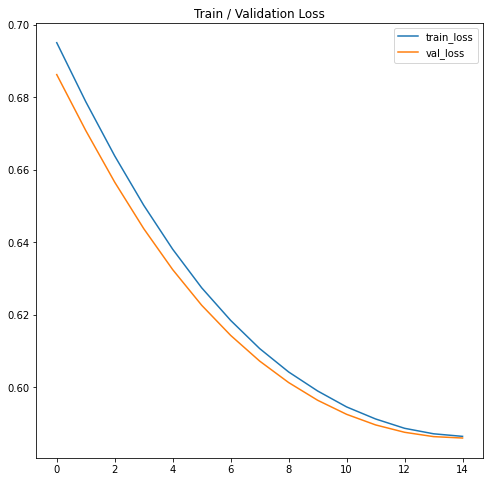

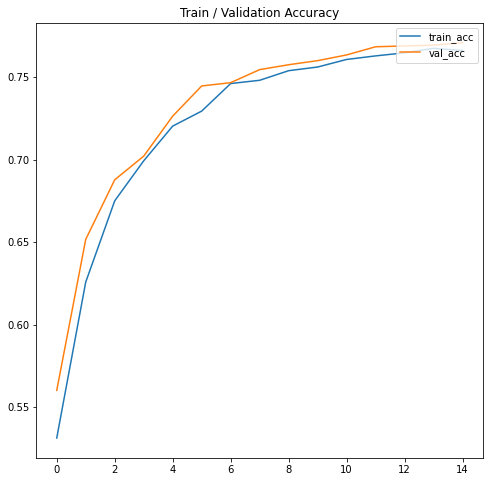

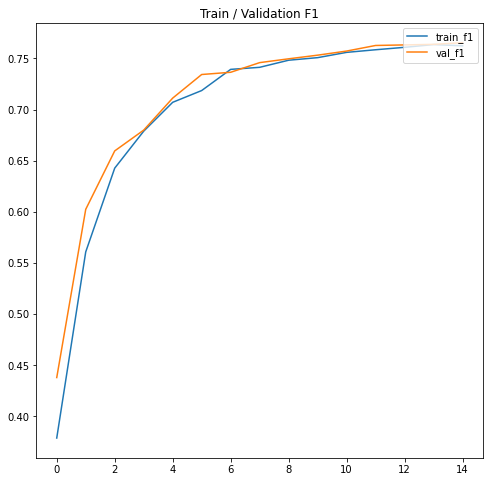

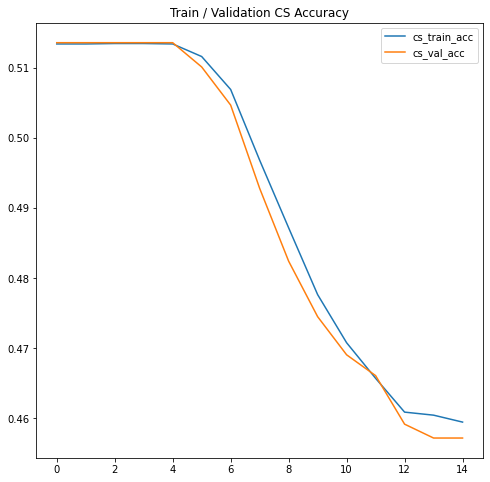

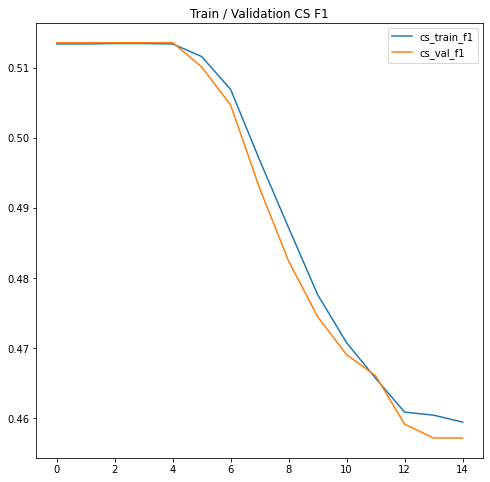

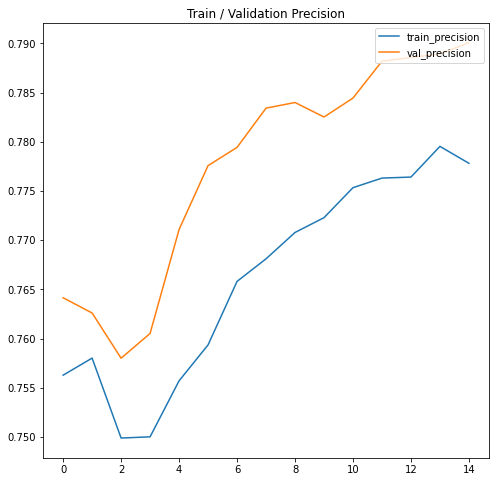

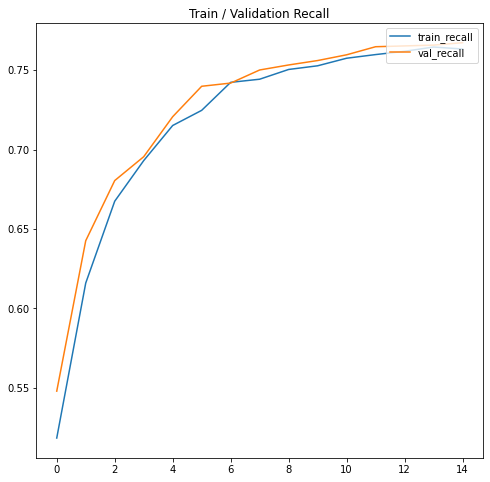

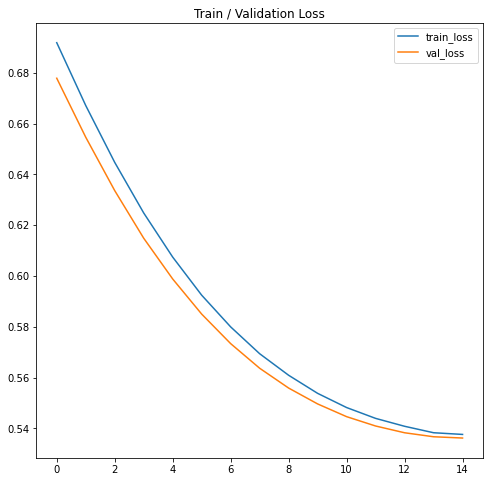

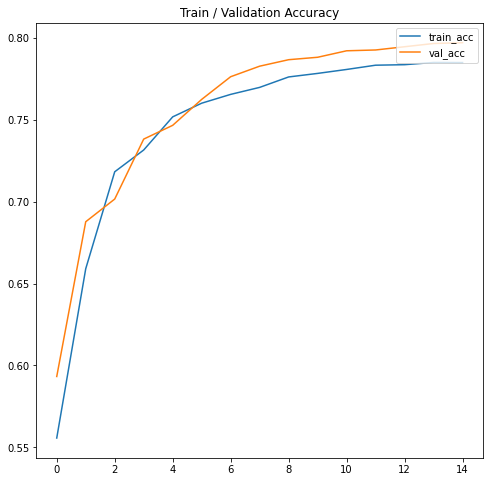

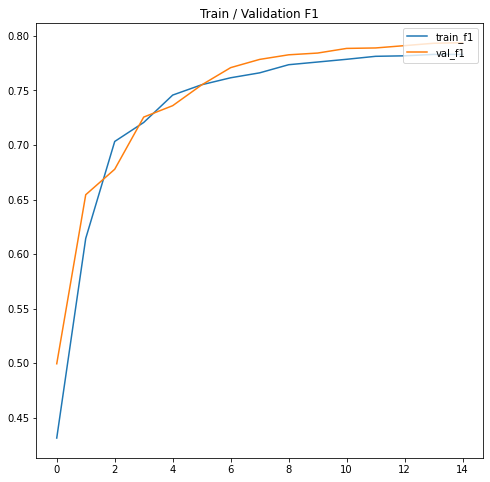

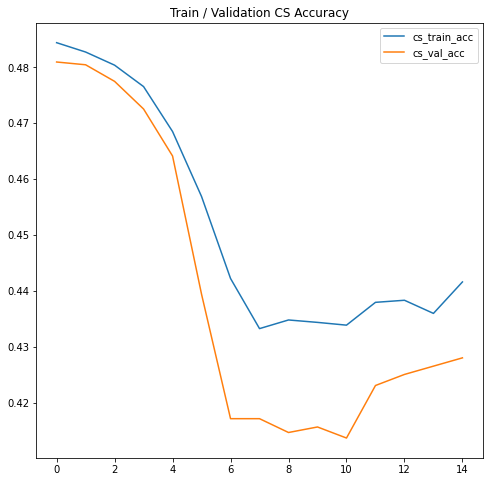

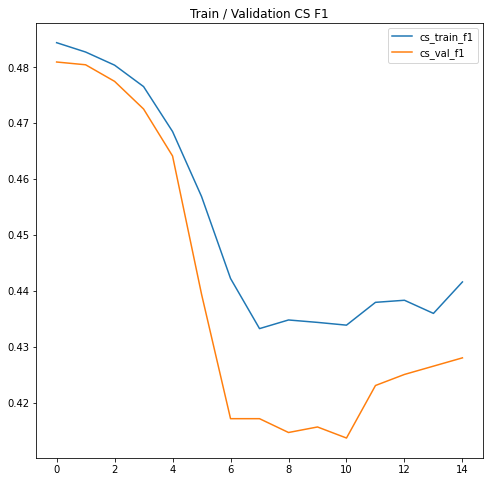

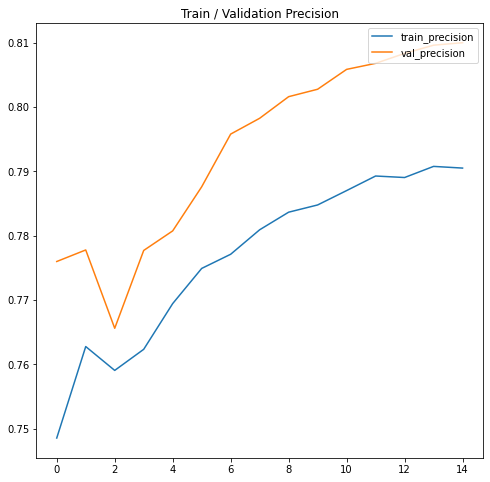

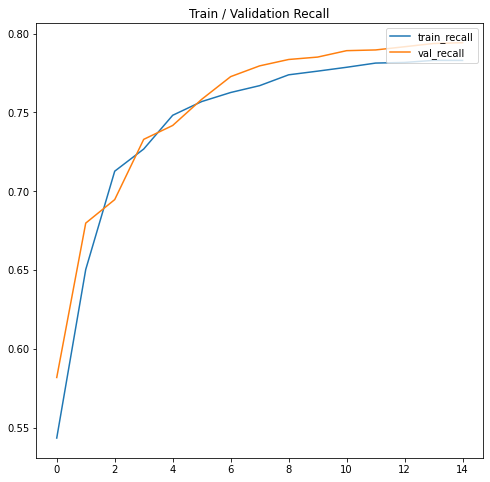

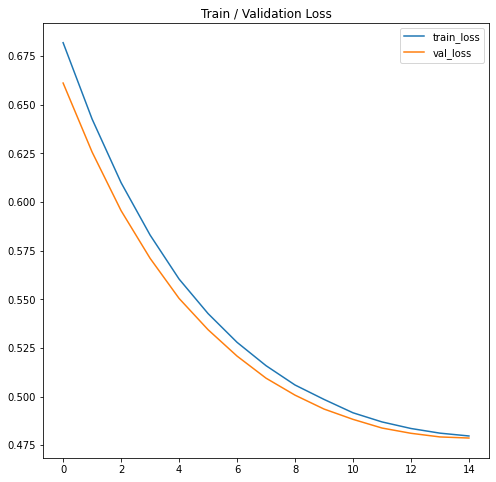

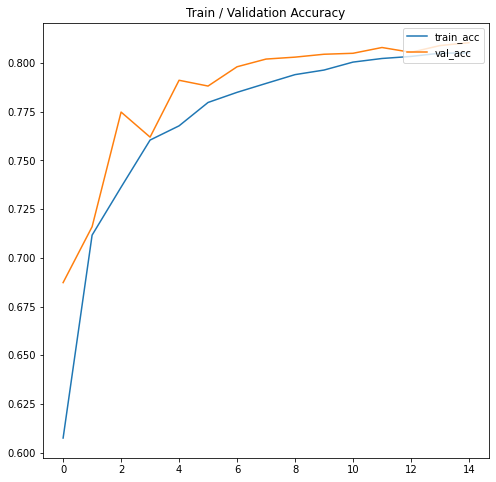

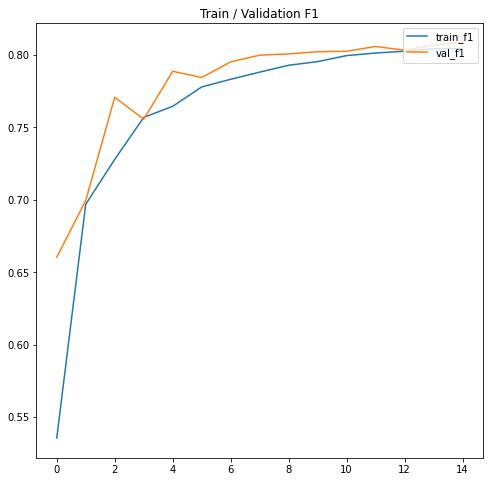

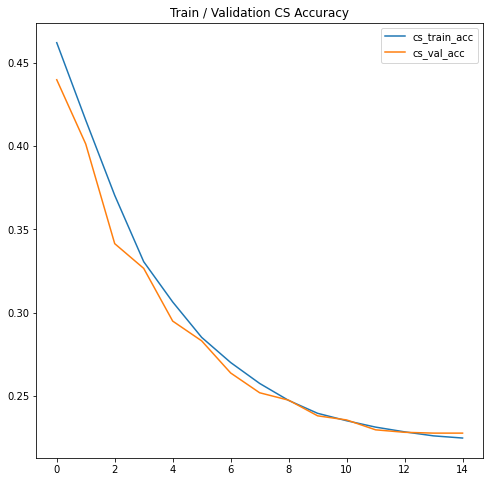

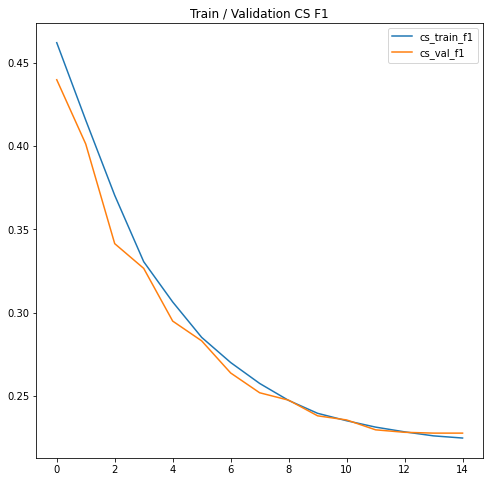

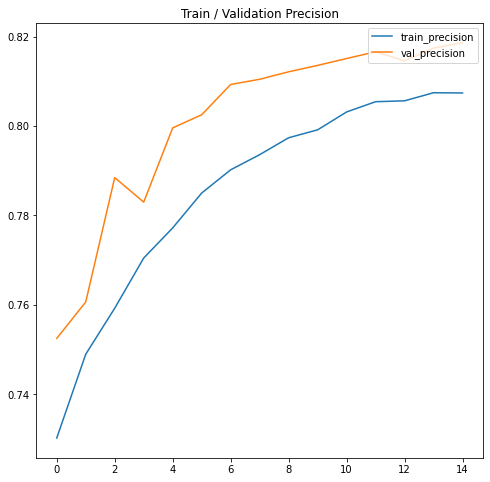

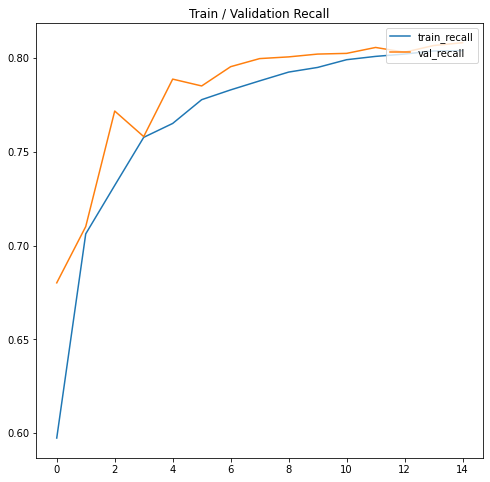

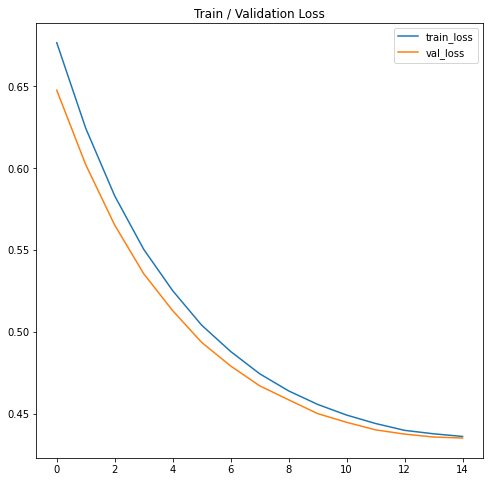

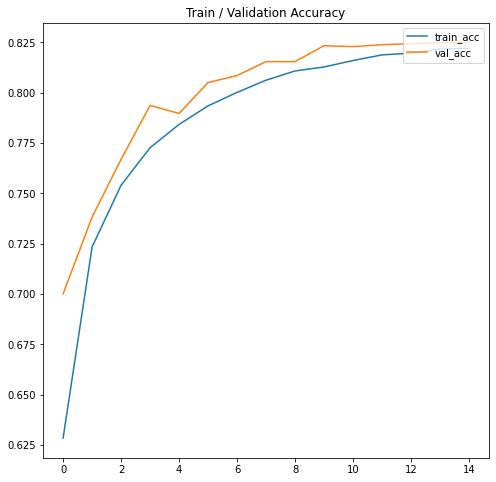

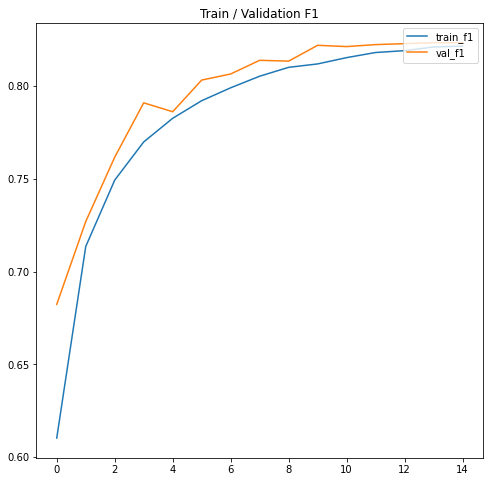

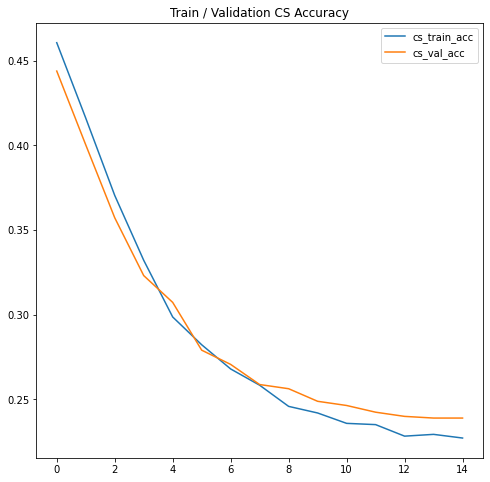

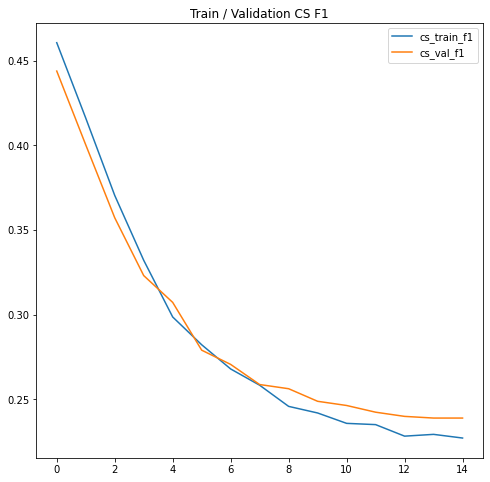

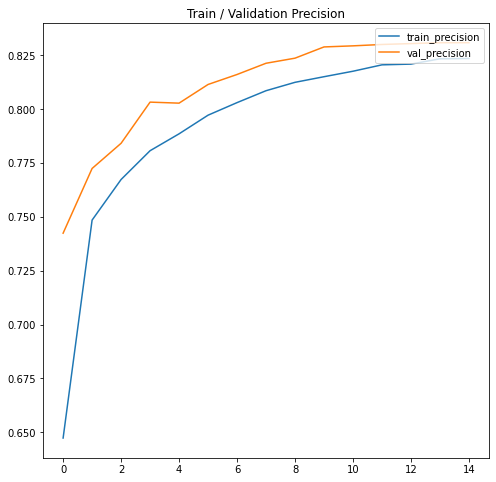

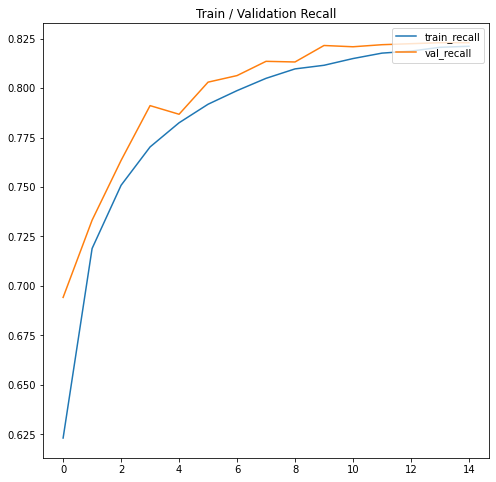

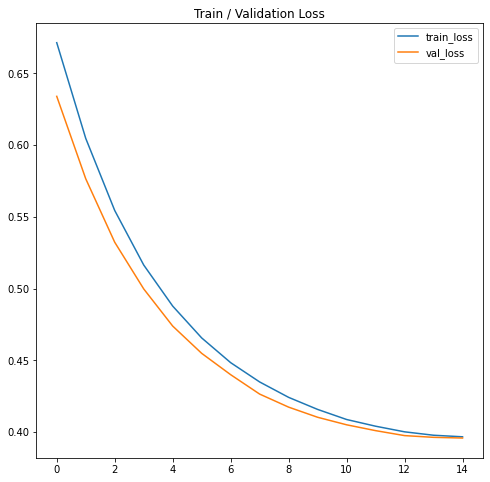

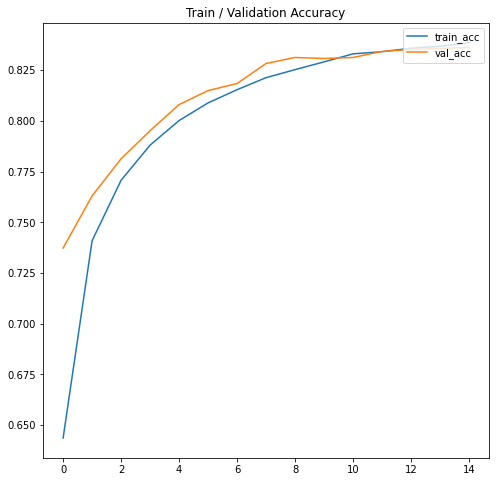

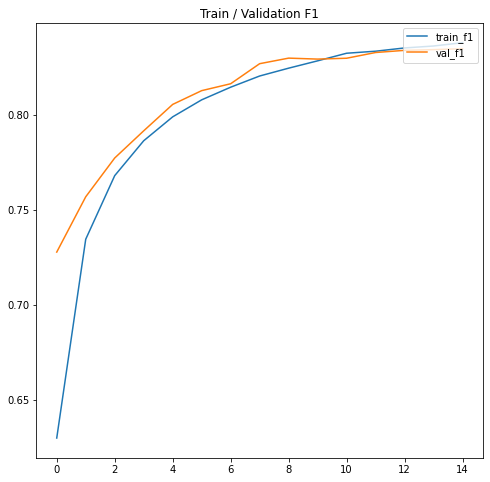

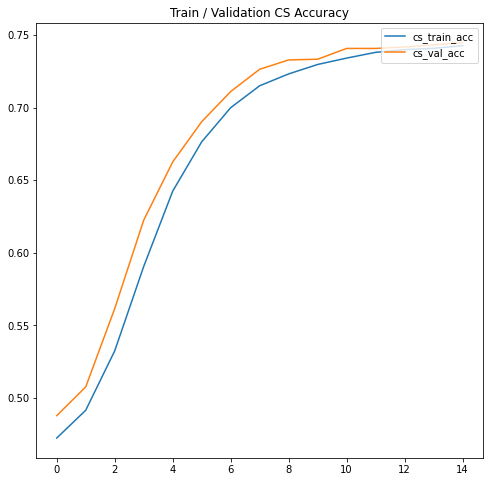

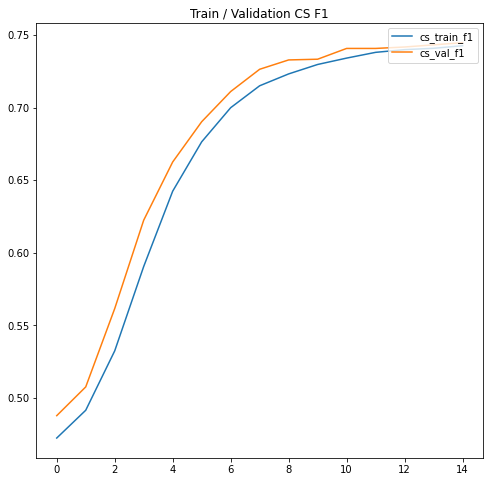

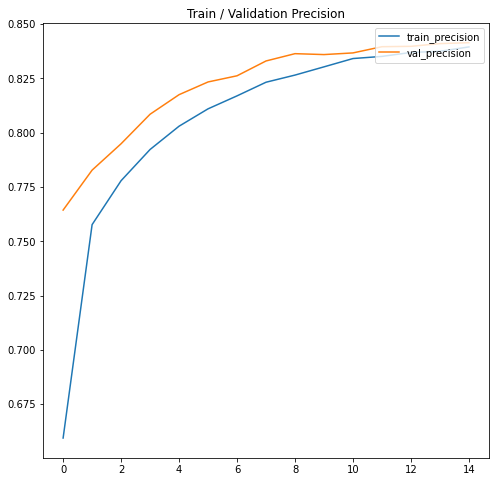

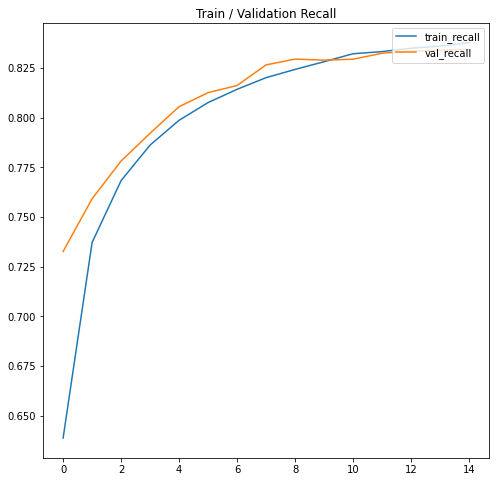

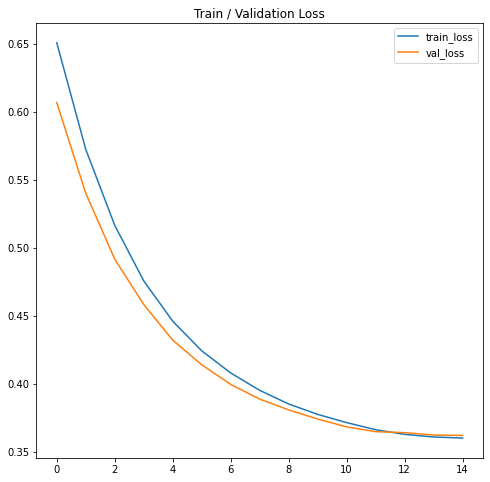

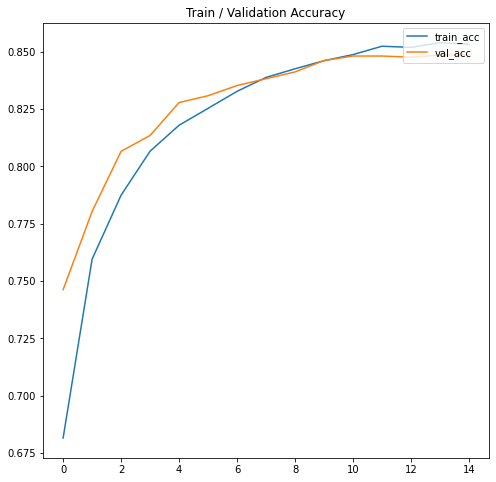

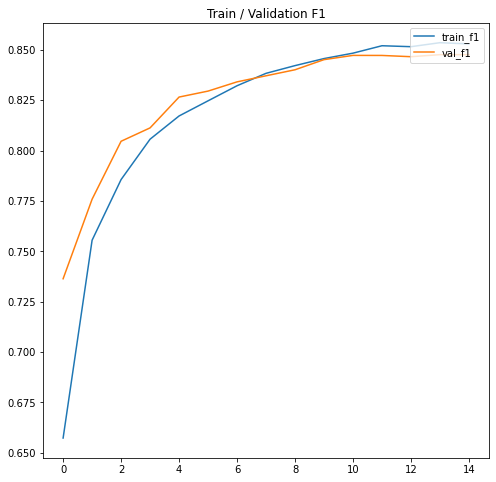

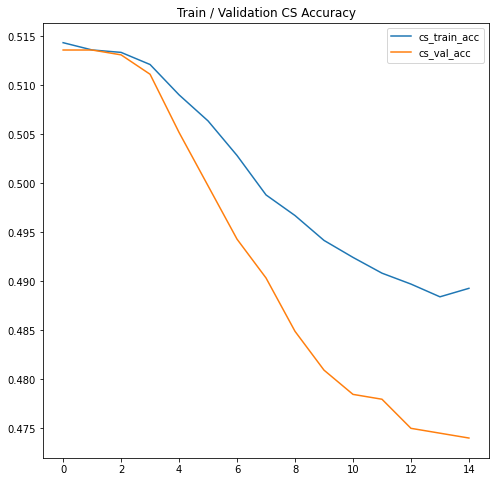

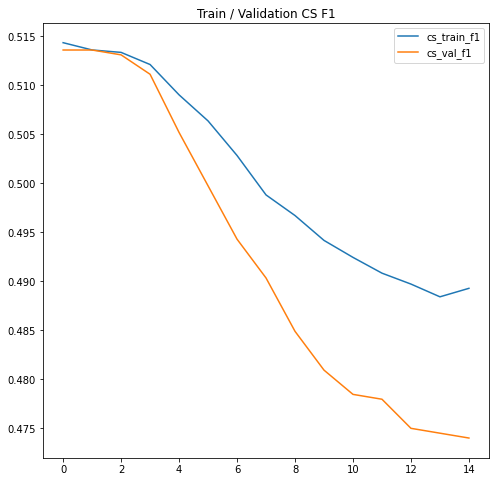

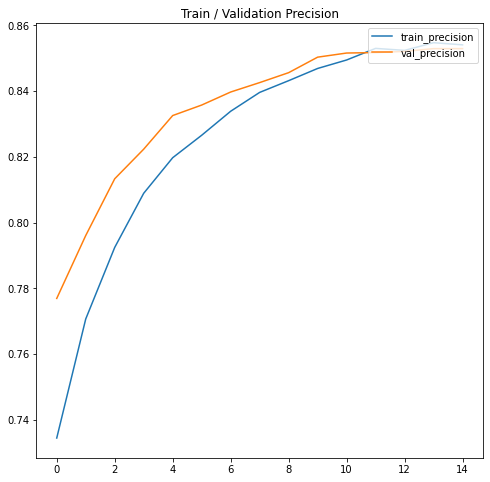

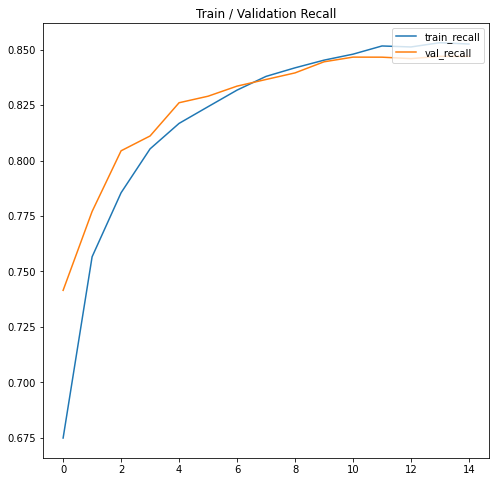

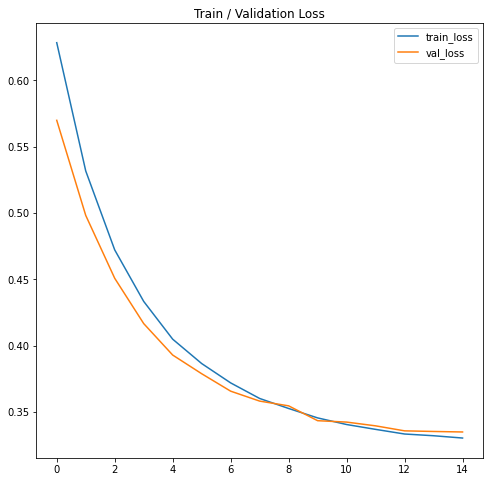

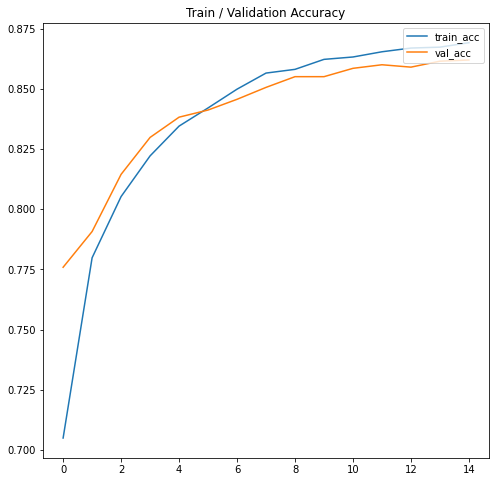

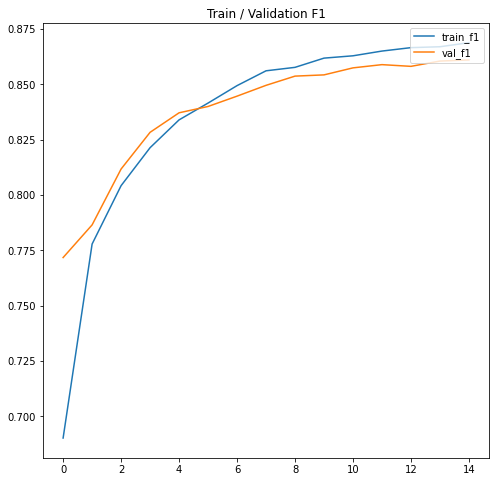

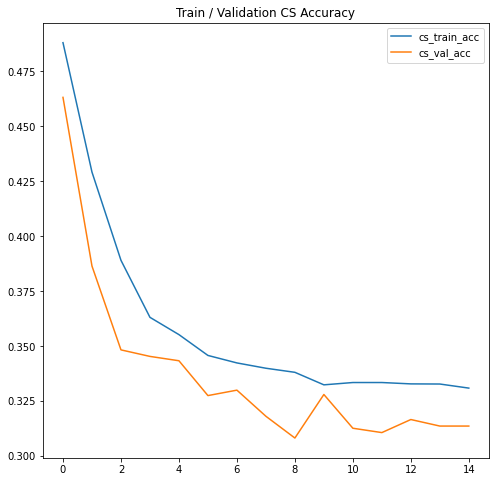

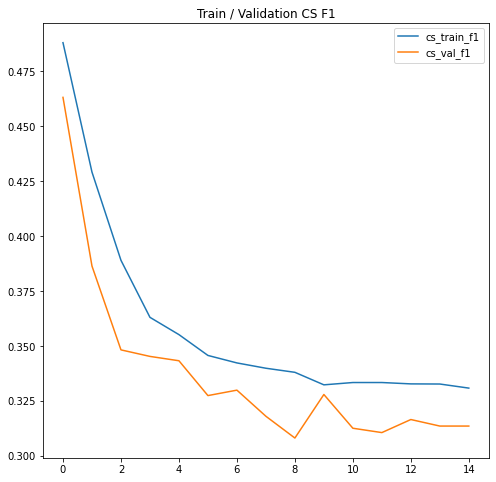

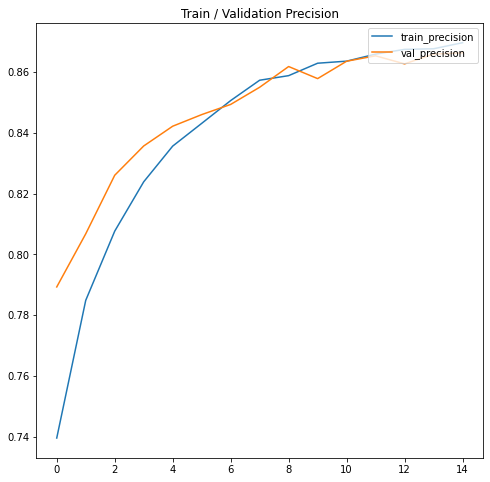

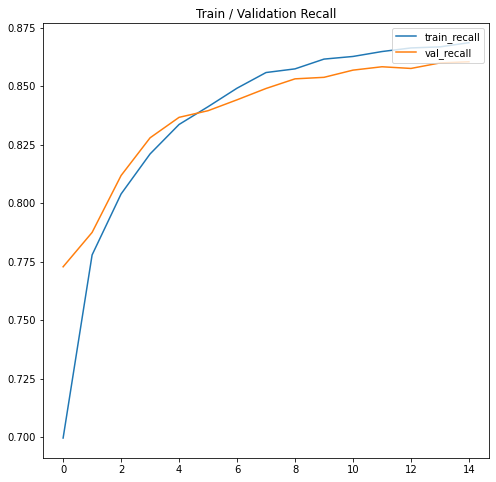

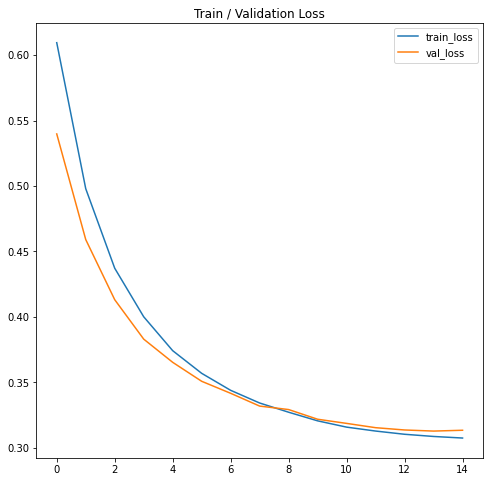

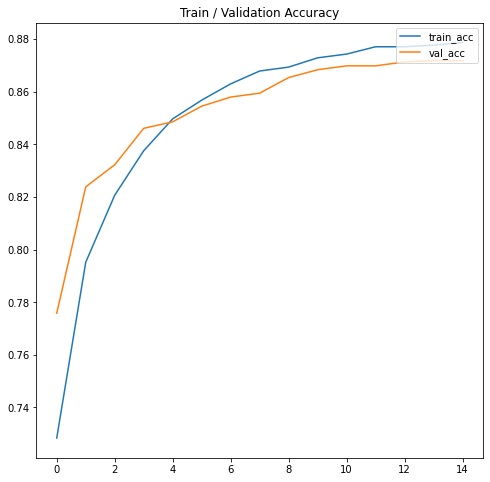

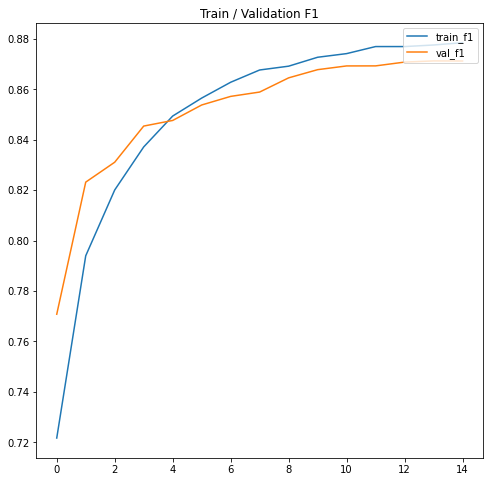

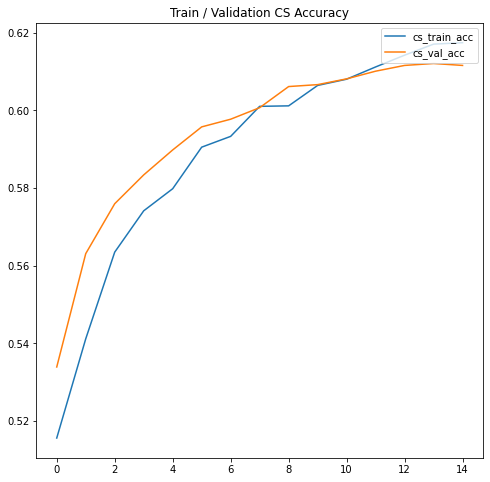

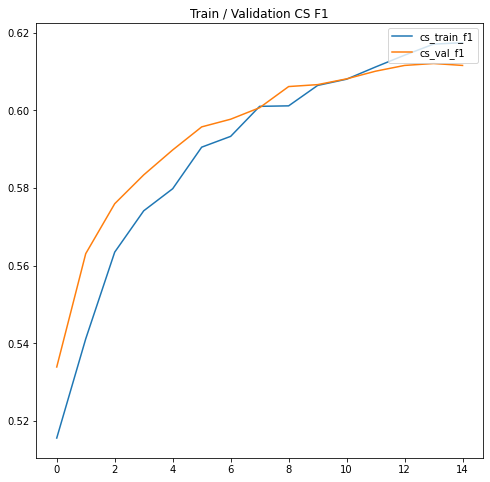

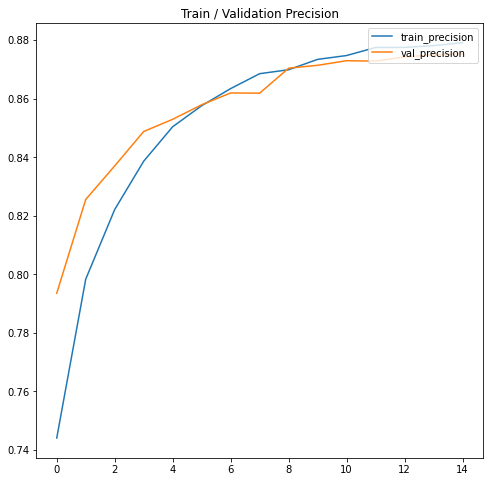

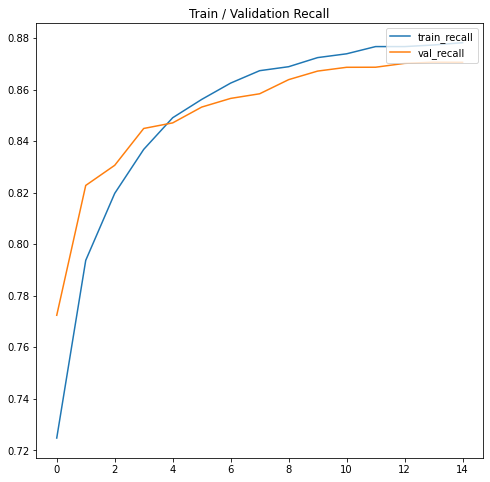

In [22]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.01,
        'l2': 1e-7,
        'ce_w': 1.0,
        'model_name': 'distilbert-base-cased',
        'dataset_name': 'fake',
        'prepare_dataset': prepare_fake,
        'num_labels': 2,
    })()

In [23]:
for lat in latents:
    print('Latents:', lat)
    train_wrapper(device_id=0, train_base=False, train_space=True, experiment_name='latents', n_latent=lat, config={
        'l1': 0.01,
        'l2': 1e-7,
        'ce_w': 1.0,
        'model_name': 'distilbert-base-cased',
        'dataset_name': 'imdb',
        'prepare_dataset': prepare_dataset,
        'num_labels': 2,
    })()

Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp16': False, 'max_grad_norm': 1000, 'weight_decay': 0.01, 'num_warmup_steps': 0, 'gradient_accumulation_steps': 1, 'n_latent': 4, 'l1': 0.01, 'l2': 1e-07, 'cross_entropy_weight': 1.0, 'preds_from_logits_func': <function get_preds_from_logits at 0x770a25ce48b0>, 'get_data_func': <function prepare_dataset at 0x770a25ce44c0>, 'init_space_func': <function init_space at 0x770a25ce4e50>, 'init_base_func': <function init_base at 0x770a25ce4ca0>}
Loading dataset...


Latents: 4


Training space model...
Number of space model parameters: 6162
Inter-space loss: 0.5225070714950562
Intra-space loss: 0.0022249945905059576
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Train loss: 0.6995920015219301 | Val loss: 0.692230441147768
Train acc: 0.5568 | Val acc: 0.6836
CS Train acc: 0.5003 | CS Val acc: 0.4988
Train f1: 0.4611039363682423 | Val f1: 0.6637096927794602
CS Train f1: 0.33346664000533227 | CS Val f1: 0.3327995729917267
Train precision: 0.6945218555155095 | Val precision: 0.7420085622097262
Train recall: 0.5565473603570498 | Val recall: 0.6841876209206965
Epoch: 2
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Train loss: 0.685182238729617 | Val loss: 0.6779964852936661
Train acc: 0.7369 | Val acc: 0.739
CS Train acc: 0.5003 | CS Val acc: 0.4988
Train f1: 0.732682977739

Initial GPU Usage
GPU memory occupied: 16236 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14022 MB.


Evaluating space model on test set:
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Train loss: 0.5740828363659283 | Val loss: 0.5670105777209318
Train acc: 0.801 | Val acc: 0.803
CS Train acc: 0.50135 | CS Val acc: 0.5056
Train f1: 0.8007076600594647 | Val f1: 0.8028387299675643
CS Train f1: 0.3752618768876571 | CS Val f1: 0.42092148819804265
Train precision: 0.8027257438967477 | Val precision: 0.8041519162709009
Train recall: 0.800977308351831 | Val recall: 0.8030732657020104
Epoch: 8
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.00it/s]

Train loss: 0.561609689800884 | Val loss: 0.5557218563707569
Train acc: 0.80115 | Val acc: 0.8058
CS Train acc: 0.5034 | CS Val acc: 0.5078
Train f1: 0.8009123485727723 | Val f1: 0.8056899350067853
CS Train f1: 0.4010973040683378 | CS Val f1: 0.4459143761421402
Train precision: 0.802549085948542 | Val precision: 0.8066265664160401
Train recall: 0.8011295584066411 | Val recall: 0.8058617617

Initial GPU Usage
GPU memory occupied: 16232 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14022 MB.


/home/stepan/cam-explain/train.py:231: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 8))
Evaluating space model on test set:
100%|█████████████████████████████████████████| 391/391 [02:10<00:00,  3.00it/s]
Val loss: 0.4627493985778535
Val acc: 0.81484
CS Val acc: 0.21704
Val f1: 0.8148257901755562
CS Val f1: 0.2123064735920027
Val precision: 0.8149366699368117
Val recall: 0.81484
Starting...
Config: {'experiment_name': 'latents', 'log_terminal': True, 'device_id': 0, 'train_base': False, 'train_space': True, 'seed': 42, 'dataset_name': 'imdb', 'model_name': 'distilbert-base-cased', 'num_labels': 2, 'num_epochs': 15, 'iterations': 1, 'max_seq_len': 512, 'batch_size': 64, 'lr': 2e-05, 'fp1

Latents: 32


Training space model...
Number of space model parameters: 49282
Inter-space loss: 0.6477934122085571
Intra-space loss: 0.016666794195771217
****************************** Iteration: 1 ******************************
Train steps: 4687
Steps per epoch: 312.5
Epoch: 1
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Train loss: 0.6752521252860657 | Val loss: 0.6484052033364018
Train acc: 0.69255 | Val acc: 0.7744
CS Train acc: 0.49815 | CS Val acc: 0.4962
Train f1: 0.6896145098276014 | Val f1: 0.7742280159334174
CS Train f1: 0.3345336325737413 | CS Val f1: 0.33616103958393456
Train precision: 0.7002300901539197 | Val precision: 0.7753827739521073
Train recall: 0.6926085993390958 | Val recall: 0.7744707009512375
Epoch: 2
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.03it/s]

Train loss: 0.44789316736090296 | Val loss: 0.4417337548883655
Train acc: 0.82105 | Val acc: 0.8232
CS Train acc: 0.23385 | CS Val acc: 0.2306
Train f1: 0.8210

Initial GPU Usage
GPU memory occupied: 16232 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14022 MB.


Evaluating space model on test set:
 19%|████████▏                                 | 76/391 [00:25<01:48,  2.90it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.01it/s]

Train loss: 0.630165116093791 | Val loss: 0.5657988447177259
Train acc: 0.75855 | Val acc: 0.8024
CS Train acc: 0.45915 | CS Val acc: 0.4154
Train f1: 0.7573525195183555 | Val f1: 0.802398861817444
CS Train f1: 0.3369161866013724 | CS Val f1: 0.3180655607990396
Train precision: 0.7636685535671008 | Val precision: 0.802398861817444
Train recall: 0.7585081230629243 | Val recall: 0.802398861817444
Epoch: 2
100%|███████████████████████████████████████████| 79/79 [00:26<00:00,  3.01it